## LLM

In [31]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [32]:
tokenizer = pkl.load(open("tokenizer_CNN8000_2.pkl", 'rb'))
tokenizer.create_hash()

random.seed(42)
corpus_indicies = pkl.load(open('corpus/CNN_tokenized8000_2.pkl', 'rb'))
random.shuffle(corpus_indicies)

## Define Model

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 256
embed_dim = 1024
tf_blocks = 8
heads = 8
ff_dim = 4096

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                          max_seq_len=max_seq_len,
                          embed_dim=embed_dim,
                          tf_blocks=tf_blocks,
                          heads=heads,
                          ff_dim = ff_dim,
                          unembed_dims=unembed_dims,
                          lr=0.00001,
                          )

losses_train = []
losses_test = []


In [4]:
ckpt = tf.train.Checkpoint(
    optimizer=model.optimizer,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/model_8k_tokens_2",      # folder where ckpts are saved
    max_to_keep=5                  # only keep 5 latest checkpoints
)


In [5]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [11]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 117583774


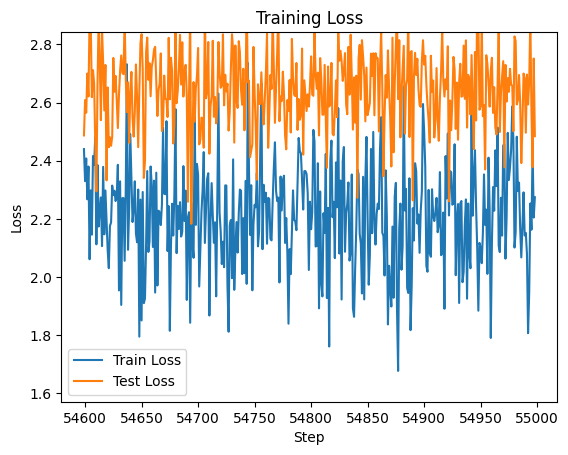

KeyboardInterrupt: 

In [6]:
batch_size = 7
model.optimizer.learning_rate = 0.000025
for i in tqdm(range(100000)):
    indices, y_true = sample_batch(corpus_indicies[:8000], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    
    loss_train = model.train_step(indices, y_true)
    losses_train.append(loss_train)

    indices, y_true = sample_batch(corpus_indicies[8000:], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    loss_test = model.evaluate(indices, y_true)
    losses_test.append(loss_test)

    if (i+1) % 1000 == 0:
        ckpt_manager.save()

    clear_output(wait=True)
    x = np.arange(max(0, len(losses_train)-400), len(losses_train))
    plt.plot(x, losses_train[-400:], label="Train Loss")
    plt.plot(x, losses_test[-400:], label="Test Loss")

    Min = np.min(losses_train[-400:])
    Max = np.max(losses_train[-400:])
    delta = Max - Min
    plt.ylim(Min - delta*0.1, Max + delta*0.1)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

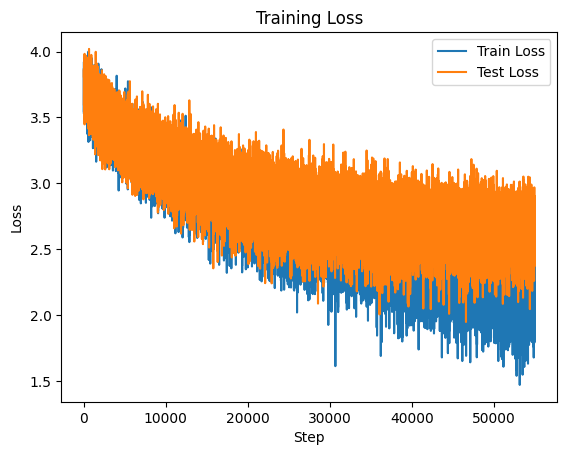

In [7]:
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
def tokenize(indices, merge_list):
    indices = np.array(indices)
    for pair, new_idx in merge_list:
        slice = np.where(np.logical_and(indices[:-1] == pair[0],  indices[1:] == pair[1]))
        if len(slice[0]) > 0:
            indices[:-1][slice] = new_idx
            indices = np.delete(indices, (slice[0]+1))

    return tf.expand_dims(tf.convert_to_tensor(indices, dtype=tf.int32), axis=0)

In [29]:
text = "Prices are soaring in the market."

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

tf.Tensor(
[[  49 1265  112    1  156    1  218 1158    1   95    1   98    1 2111
    15]], shape=(1, 15), dtype=int32)


In [30]:
T = 0.25
tf.random.set_seed(42)
for i in range(256):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


KeyboardInterrupt: 

## 